In [16]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

%matplotlib inline

In [17]:
# Set a few configuration parameters.
img_height = 480
img_width = 640
n_classes = 4
model_mode = 'inference'

In [28]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd7_epoch-25_loss-3.0395_val_loss-2.7676.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

In [29]:
dataset = DataGenerator()

# TODO: Set the paths to the dataset here.
Pascal_VOC_dataset_images_dir = '../datasets/ICUB/testseenimg/'
Pascal_VOC_dataset_annotations_dir = '../datasets/ICUB/testseenans/'
Pascal_VOC_dataset_image_set_filename = '../datasets/ICUB/testseen.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background','book','cellphone','mouse','ringbinder']
           

dataset.parse_xml(images_dirs=[Pascal_VOC_dataset_images_dir],
                  image_set_filenames=[Pascal_VOC_dataset_image_set_filename],
                  annotations_dirs=[Pascal_VOC_dataset_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

Processing image set 'testseen.txt': 100%|██████████████████████████████████████████| 320/320 [00:00<00:00, 665.80it/s]


In [ ]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=4,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.2,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 320

Producing predictions batch-wise:  38%|██████████████████                              | 30/80 [04:15<07:06,  8.53s/it]

In [22]:
import numpy as np
np.savez('Test_Results/SSD7_4_seen_GOOGLE.npz', mean_average_precision=mean_average_precision, average_precisions=average_precisions,precisions=precisions,recalls=recalls)

In [13]:
import numpy as np
data = np.load('Test_Results/SSD7_6_unseen.npz')
mean_average_precision = data['mean_average_precision']
average_precisions = data['average_precisions']
precisions = data['precisions']
recalls = data['recalls']

In [8]:
print(len(precisions))

7


In [27]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', mean_average_precision, 3))

book          AP    0.725
cellphone     AP    0.568
mouse         AP    0.961
ringbinder    AP    0.052

              mAP   0.5764357697421724


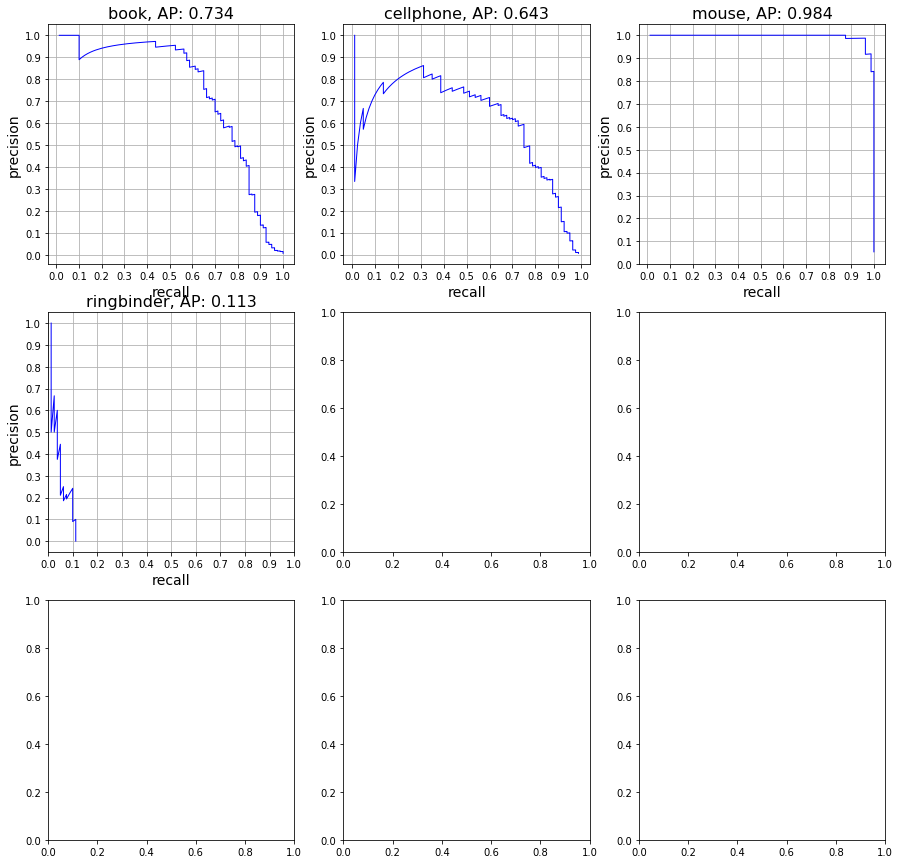

In [23]:
m = max((n_classes + 1) // 3, 3)
n = 3

fig, cells = plt.subplots(m, n, figsize=(n*5,m*5))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

In [9]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.5,
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)

mean_average_precision = evaluator.compute_mean_average_precision(ret=True)

Matching predictions to ground truth, class 4/4.: 100%|███████████████████████| 12573/12573 [00:00<00:00, 29476.31it/s]
Computing precisions and recalls, class 1/4
5
Computing precisions and recalls, class 2/4
5
Computing precisions and recalls, class 3/4
5
Computing precisions and recalls, class 4/4
5
Computing average precision, class 1/4
Computing average precision, class 2/4
Computing average precision, class 3/4
Computing average precision, class 4/4


In [10]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

book          AP    0.338
cellphone     AP    0.45
mouse         AP    0.936
ringbinder    AP    0.059

              mAP   0.446


In [7]:
evaluator??